# Elastic Impedance

Connolly introduced the concept of elastic impedance ($EI$) in 1999 as an elegant solution to tie the interpretation of far angle stacks to well data (near-offsets can be tied to well data through simple acoustic impedance).

He rearranged the Aki-Richards equations so that the output is not reflectivity but something like a proper log, which is strikingly similar in shape to acoustic impedance ($AI$), until something interesting happens (like a hydrocarbon-bearing sand) and then elastic impedance shows a different response from $AI$.

The formula looks like this:

$$ EI = V_p^a V_s^b \rho^c $$

where:

$$ a = 1 + \tan^2 \theta $$
$$ b = -8 k \sin^2 \theta $$
$$ c = 1 - 4 k \sin^2 \theta $$
$$ k = \left( \frac{V_s}{V_p} \right)^2 $$

The $k$ factor is usually kept constant in a given area.

Connolly also presents an alternative form which "can be used for generating synthetics" (his own words, check the Appendix in Connolly, 1999):
    
$$ EI = V_p \rho^* $$
$$ \rho^\ast = V_p^{(\tan^2 \theta)} V_s^b \rho^c ) $$

In practice we have $EI$ expressed as the product of velocity and a pseudo-density ($ \rho^* $) that is angle-dependant. So any kind of 1D modeling can be used to generate angle-dependant synthetic seismograms, and the usual calibration of $ V_p $ through time-depth tables ensures the correct positioning in time. 

Whitcome in 2002 introduced the normalized $EI$ function to allow comparisons between $EI$ logs calculated at different angles:

$$ EI^{NORM} = \rho_0 V_{p0} \, \left[ \left( \frac{V_p}{V_{p0}}\right)^a  \left( \frac{V_s}{V_{s0}} \right)^b  \left( \frac{\rho}{\rho_0} \right)^c\right]$$


Where the scaling factors $V_{p0}$ $V_{s0}$ $\rho_0$ are averages of the input elastic logs computed over the range of interest or the values at the top of the target zone.
 
I discuss some practical aspects of using elastic impedance in the context of generating synthetic seismograms and also show how I reproduced a couple of figures from "Seismic Amplitude" by Simm & Bacon in this notebook here: ["The relationship between reflectivity and elastic impedance", or how to reproduce figure 5.62 from Seismic Amplitude by Simm & Bacon (2014)](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/relationship-reflectivity-elastic-impedance_Simm-Bacon.ipynb).

## references

* Connolly, Elastic impedance, The Leading Edge, 1999.
* Whitcombe, Elastic impedance normalization, Geophysics, 2002.
* Simm & Bacon, Seismic Amplitude: An Interpreter's Handbook, Cambridge University Press, 2014.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

In [2]:
def elastic_impedance(vp, vs, rho, alpha, scal=None, k=0.25):
    alpha = np.radians(alpha)
    a = 1 + (np.tan(alpha)) ** 2
    b = -8 * k * ((np.sin(alpha)) ** 2)
    c = 1 - 4 * k * ((np.sin(alpha)) ** 2)
    if scal is None:
        ei = vp**a * vs**b * rho** c
    else:
        vp0, vs0, rho0 = scal[0], scal[1], scal[2]
        ei = vp0*rho0 * ( (vp/vp0) ** a * (vs/vs0) ** b * (rho/rho0) ** c)
    return ei

In [16]:
ll=np.recfromcsv('qsiwell2_frm.csv')
z=ll['depth']
gr=ll['gr']
ip=ll['ip']
vp=ll['vp']
vs=ll['vs']
rho=ll['rho']
# need to check if input logs are insitu or brine
#vp=ll['vp_frmb']
#vs=ll['vs_frmb']
#rho=ll['rho_frmb']

z1, z2 = 2100, 2150
f = (z>=z1) & (z<=z2)
# k = (np.nanmean(vs[f]) / np.nanmean(vp[f])) ** 2  # avg over interval of interest
scal=np.nanmean([vp[f], vs[f], rho[f]], axis=1)

ei = elastic_impedance(vp,vs,rho,30)
ei_norm = elastic_impedance(vp,vs,rho,30,scal)

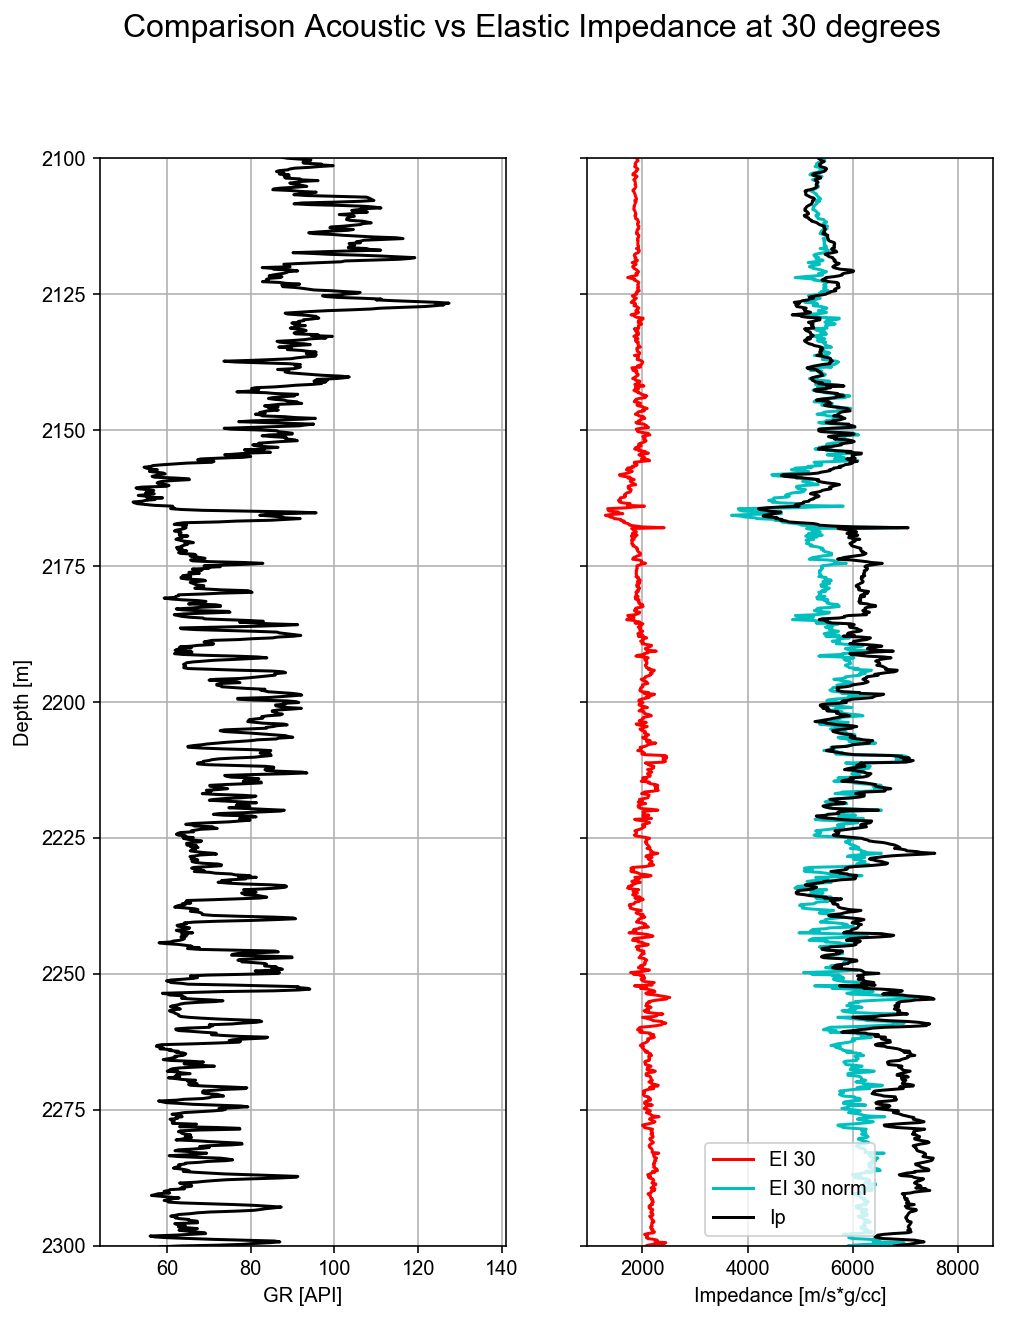

In [17]:
f, ax = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(8,10))
ax[0].plot(gr,z,'k')
ax[1].plot(ei,z,'r', label='EI 30')
ax[1].plot(ei_norm,z,'c', label='EI 30 norm')
ax[1].plot(ip,z,'k', label='Ip')

ax[0].set_ylim(2100,2300)
ax[0].invert_yaxis()
ax[0].set_xlabel('GR [API]')
ax[1].set_xlabel('Impedance [m/s*g/cc]')
ax[0].set_ylabel('Depth [m]')
ax[1].locator_params(nbins=5, axis='x')
ax[0].grid(which='both')
ax[1].grid(which='both')
ax[1].legend()
f.suptitle('Comparison Acoustic vs Elastic Impedance at 30 degrees', fontsize=16)

## How to calculate EI in commercial software

Just as an additional (and potentially useful) piece of information, here's how you would specify the constants discussed above ($k$ plus the scaling factors $V_{p0}$ $V_{s0}$ $\rho_0$) in the well-tie module ("Well Seismic Fusion") in Halliburton's Decision Space:

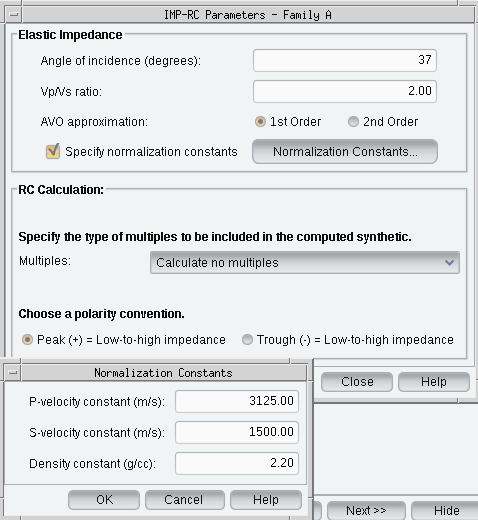

In [2]:
from IPython.display import Image
Image(filename='DecisionSpace_welltie_EI_Calc.png', width=400)

I haven't found further details on this but it looks like that you have indeed to specify the _Vp/Vs ratio_ and not the $k$ constant, so given $Vp/Vs = 2$ then $ k = (Vs/Vp)^2 = 0.25 $.

The _normalization constants_ are those that I call scaling factors.